Importing Modules and Seed Setting

In [2]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import json
import gc

import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import torchvision.models as models
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights, fcn_resnet50
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import cv2
from skimage import morphology, measure
from skimage.morphology import binary_closing, binary_opening, remove_small_objects
from shapely.geometry import Polygon
from shapely.ops import unary_union

#Random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Parameters Configuration

In [ ]:
path = Path("./preprocessed_patches") 
batch_size = 8
learning_rate = 0.001
max_epochs = 50
rgb_channels = 3 
segmentation_classes = 1 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


Data Transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10)
])

Dataset Class

In [5]:
class SatellitePatchDataset(Dataset):
    def __init__(self, path, transform=None, is_training=True):
        self.path = Path(path)
        self.image_paths = []
        self.mask_paths = []
        self.transform=transform
        self.is_training = is_training
        
        #Collecting image-mask pairs
        for city_dir in self.path.iterdir():
            if city_dir.is_dir():
                for img_path in city_dir.glob("patch_*.png"):
                    if "_gt.png" not in img_path.name:
                        mask_path = img_path.parent / f"{img_path.stem}_gt.png"
                        if mask_path.exists():
                            self.image_paths.append(img_path)
                            self.mask_paths.append(mask_path)
                        else:
                            print(f"Warning: Corresponding mask not found for {img_path}")

        print(f"Found {len(self.image_paths)} image-mask pairs across all cities.")
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):        
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        #Load and preprocess image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        #Converting to numpy arrays and normalizing
        image = np.array(image, dtype=np.float32) / 255.0 
        mask = np.array(mask, dtype=np.float32) / 255.0
        
        #Applying random transformations to both image and mask
        if self.transform and self.is_training:
            #Convert to PIL for transformations
            image_pil = transforms.ToPILImage()(image.transpose(2, 0, 1))
            mask_pil = transforms.ToPILImage()(mask)
            
            #Applying Random Seed
            seed = random.randint(2147483647)
            
            torch.manual_seed(seed)
            mask_pil = self.transform(mask_pil)
            
            #Converting back to numpy
            image = np.array(image_pil, dtype=np.float32) / 255.0
            mask = np.array(mask_pil, dtype=np.float32) / 255.0
            
        #Converting to proper tensor format
        image = np.transpose(image, (2, 0, 1)) # HWC to CHW
        mask = np.expand_dims(mask, axis=0) #Adding channel dimension
        
        #Converting to tensor
        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask)   
        
        #Ensuring the mask is binary
        mask_tensor = (mask_tensor > 0.5).float()
        
        return image_tensor, mask_tensor


U-Net Model Architecture

In [ ]:
#U-Net Model Components

class DoubleConv(nn.Module):
    """Double convolution block with BatchNorm and ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling block with maxpool followed by double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling block with transpose conv and skip connections"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        #Handle Size Mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        #Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    """Final output convolution"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """Complete U-Net Architecture"""
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        #Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        #Decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        #Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        #Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits


Evaluation Metrics

In [7]:
def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union (IoU)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return (intersection / union).item()

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate precision, recall, F1-score and IoU"""
    pred_binary = (predictions > threshold).cpu().numpy().flatten()
    target_binary = targets.cpu().numpy().flatten()
    
    precision = precision_score(target_binary, pred_binary, zero_division=0)
    recall = recall_score(target_binary, pred_binary, zero_division=0)
    f1 = f1_score(target_binary, pred_binary, zero_division=0)
    
    #Calculate IoU
    intersection = np.sum(pred_binary * target_binary)
    union = np.sum(pred_binary) + np.sum(target_binary) - intersection
    iou = intersection / union if union > 0 else 0.0
    
    return precision, recall, f1, iou

Data Loading and Splitting

In [8]:
max_epochs = 10
batch_size = 8
patience = 5

print("Loading dataset...")
full_dataset = SatellitePatchDataset(path, transform=train_transforms, is_training=True)

#Splitting dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

#Create validation dataset without augmentation
val_dataset.dataset.transform = None
val_dataset.dataset.is_training = False

#Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Estimated time per epoch: {len(train_loader) * 35 / 1800:.1f} minutes")
print(f"Total estimated training time: {len(train_loader) * 35 / 1800 * max_epochs:.1f} minutes")

Loading dataset...
Found 18000 image-mask pairs across all cities.
Training Samples: 14400
Validation Samples: 3600
Estimated time per epoch: 35.0 minutes
Total estimated training time: 350.0 minutes


Model Initialization

In [9]:
model = UNet(n_channels=rgb_channels, n_classes=segmentation_classes)
model.to(device) #Using GPU

#Loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Binary classification 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Training Loop

In [9]:
# Reset GPU state for optimal performance
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes


def load_checkpoint(checkpoint_path, model, optimizer, scheduler, device):
    """Load checkpoint and return training state"""
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        best_iou = checkpoint['best_iou']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses'] 
        val_ious = checkpoint['val_ious']
        
        print(f"Resumed from epoch {start_epoch}, best IoU: {best_iou:.4f}")
        return start_epoch, best_iou, train_losses, val_losses, val_ious
    else:
        print("No checkpoint found, starting from scratch...")
        return 0, 0.0, [], [], []

def save_checkpoint(epoch, model, optimizer, scheduler, best_iou, train_losses, val_losses, val_ious, filepath):
    """Save training checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_ious': val_ious
    }, filepath)

checkpoint_path = 'best_unet_model.pth'
start_epoch, best_iou, train_losses, val_losses, val_ious = load_checkpoint(
    checkpoint_path, model, optimizer, scheduler, device
)


# Initialize mixed precision scaler
scaler = GradScaler()

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
start_time = time.time()

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")

def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f"{int(hours)}h {int(minutes)}m"

print("Starting training...")
if start_epoch > 0:
    print(f"Resuming from epoch {start_epoch + 1}")
print_gpu_memory()

for epoch in range(start_epoch, max_epochs):
    epoch_start_time = time.time()
    # Clear cache at the start of each epoch
    torch.cuda.empty_cache()
    
    # Training Phase
    model.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")
    for batch_idx, (images, masks) in enumerate(train_pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Use mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Scale loss and backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        # Update progress bar every 10 batches to reduce overhead
        if batch_idx % 10 == 0:
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{running_loss/(batch_idx+1):.4f}'
            })
        
        # Clear variables to free memory
        del images, masks, outputs, loss
        
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    #Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_ious_batch = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Val]")
        for batch_idx, (images, masks) in enumerate(val_pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            val_running_loss += loss.item()
            
            # Calculate metrics
            predictions = torch.sigmoid(outputs)
            precision, recall, f1, iou = calculate_metrics(predictions, masks)
            
            val_ious_batch.append(iou)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1s.append(f1)
            
            # Update progress bar every 5 batches
            if batch_idx % 5 == 0:
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'IoU': f'{iou:.4f}'
                })
            
            # Clear variables to free memory
            del images, masks, outputs, predictions, loss
    
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_iou = np.mean(val_ious_batch)
    epoch_val_precision = np.mean(val_precisions)
    epoch_val_recall = np.mean(val_recalls)
    epoch_val_f1 = np.mean(val_f1s)
    
    val_losses.append(epoch_val_loss)
    val_ious.append(epoch_val_iou)
    
    # LEARNING RATE SCHEDULING
    scheduler.step(epoch_val_loss)
    
    # SAVE BEST MODEL
    if epoch_val_iou > best_iou:
        best_iou = epoch_val_iou
        save_checkpoint(epoch, model, optimizer, scheduler, best_iou, 
                       train_losses, val_losses, val_ious, 'best_unet_model.pth')
        print(f"New best model saved with IoU: {best_iou:.4f}")
        
    # EARLY STOPPING LOGIC
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    # TIME CALCULATIONS AND DISPLAY
    epoch_time = time.time() - epoch_start_time
    elapsed_time = time.time() - start_time
    estimated_total_time = elapsed_time * max_epochs / (epoch + 1)
    remaining_time = estimated_total_time - elapsed_time
        
    print(f"Epoch {epoch+1}/{max_epochs}:")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f}")
    print(f"  Val IoU: {epoch_val_iou:.4f}")
    print(f"  Val Precision: {epoch_val_precision:.4f}")
    print(f"  Val Recall: {epoch_val_recall:.4f}")
    print(f"  Val F1-Score: {epoch_val_f1:.4f}")
    print(f"  Epoch Time: {format_time(epoch_time)}")
    print(f"  Remaining Time: {format_time(remaining_time)}")
    print("-" * 50)
    
    # Print memory usage
    print_gpu_memory()
    
    # EARLY STOPPING CHECK
    if patience_counter >= patience:
        print(f"\nEARLY STOPPING triggered at epoch {epoch+1}")
        print(f"No improvement in validation loss for {patience} epochs")
        break

# TRAINING COMPLETE
print("Training Complete!")
print(f"Best Validation IoU: {best_iou:.4f}")

# Save final checkpoint
save_checkpoint(epoch, model, optimizer, scheduler, best_iou, train_losses, val_losses, val_ious, 'final_unet_model.pth')
print("Final model saved!")

Loading checkpoint...
Resumed from epoch 10, best IoU: 0.7312
Starting training...
Resuming from epoch 11
GPU Memory - Allocated: 0.35GB, Cached: 0.49GB
Training Complete!
Best Validation IoU: 0.7312


C:\Users\ayush\AppData\Local\Temp\ipykernel_25320\4052137500.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


NameError: name 'epoch' is not defined

Plotting Training Curves

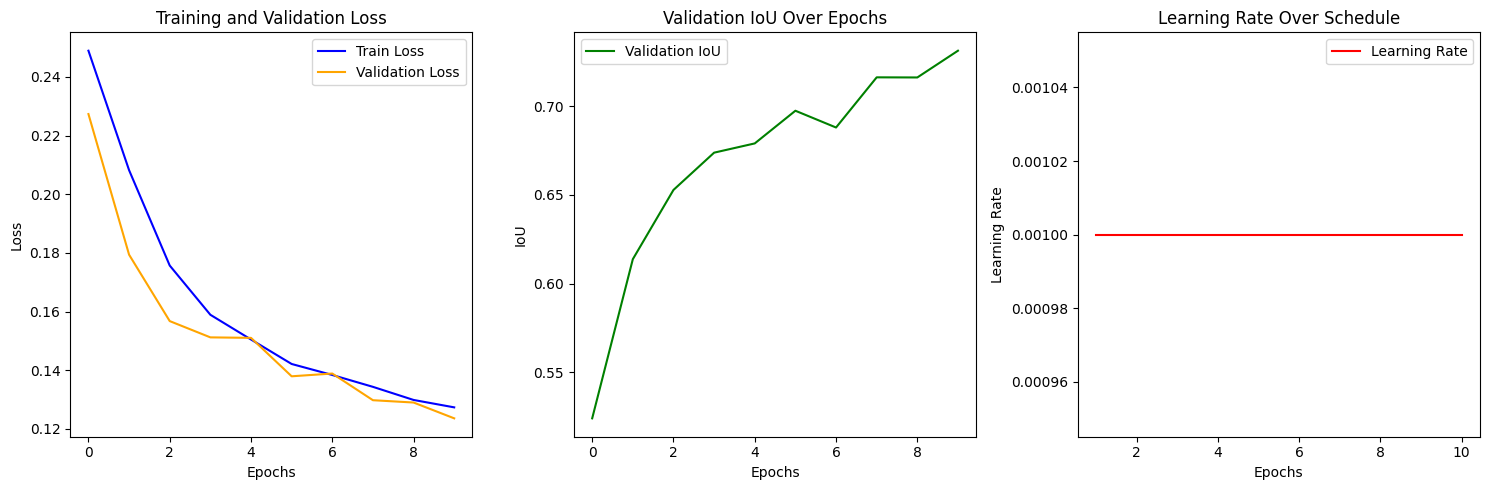

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_ious, label='Validation IoU', color='green')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Validation IoU Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, [scheduler.get_last_lr()[0]] * len(epochs), label='Learning Rate', color='red')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Schedule')
plt.legend()

plt.tight_layout()
plt.show()

Loading Final Model for Evaluation

In [11]:
checkpoint = torch.load('final_unet_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Prediction Visualization

Visualizing predictions...


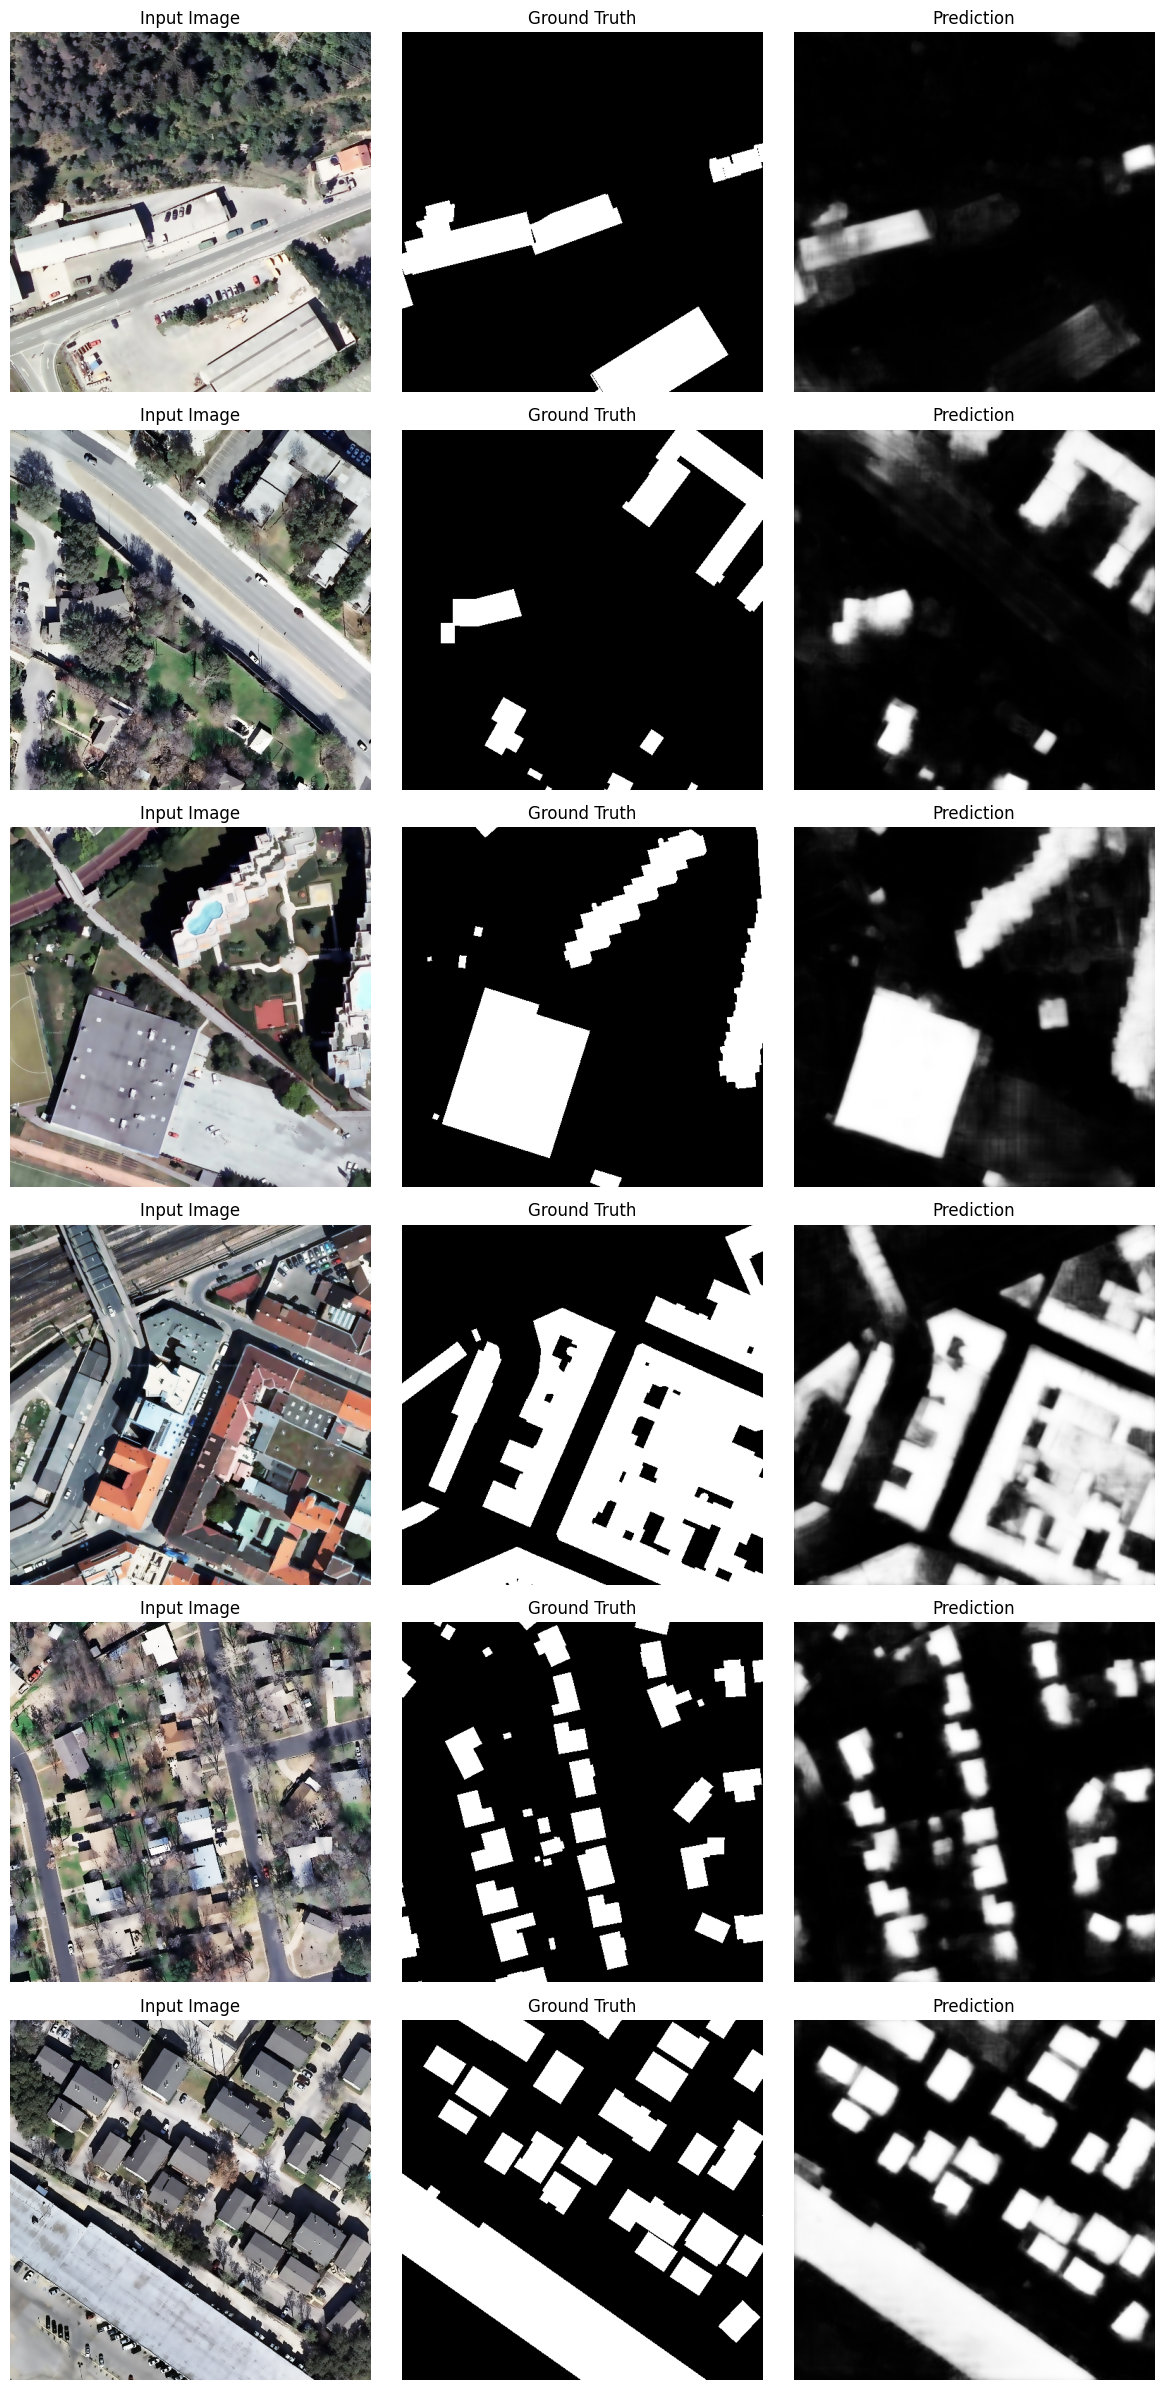

In [12]:
def visualize_predictions(model, dataset, num_samples=4):
    """Visualizing some predictions from the model"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            
            #Getting Prediction
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).squeeze().cpu()
            
            #Converting tensors for visualization
            image_vis = image.permute(1, 2, 0).cpu().numpy()
            mask_vis = mask.squeeze().cpu().numpy()
            pred_vis = prediction.numpy()
            
            #Plotting
            axes[i, 0].imshow(image_vis)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_vis, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_vis, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
    plt.tight_layout()
    plt.show()
    
print("Visualizing predictions...")
visualize_predictions(model, val_dataset, num_samples=6)

DeepLabV3+

In [ ]:
class DeepLabV3PlusOptimized(nn.Module):
    """Optimized DeepLabV3+ for faster training"""
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepLabV3PlusOptimized, self).__init__()
        
        # Use smaller backbone or reduce complexity
        self.model = deeplabv3_resnet50(pretrained=pretrained, num_classes=21)
        
        # Simplified classifier with fewer parameters
        self.model.classifier = nn.Sequential(
            nn.Conv2d(2048, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # Reduced dropout
            nn.Conv2d(128, num_classes, 1)  
        )
        
        # Simplified auxiliary classifier
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier = nn.Sequential(
                nn.Conv2d(1024, 64, 3, padding=1, bias=False),  
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, num_classes, 1)
            )
    
    def forward(self, x):
        return self.model(x)['out']

#loss function
class Loss(nn.Module):
    def __init__(self, pos_weight=None):
        super().__init__()
        self.pos_weight = pos_weight
        
    def forward(self, inputs, targets):
        return F.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)


def get_optimized_dataloader(dataset, batch_size, shuffle=True, is_training=True):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,  
        pin_memory=True,
        persistent_workers=True, 
        prefetch_factor=2, 
        drop_last=is_training  
    )

def calculate_metrics_fast(predictions, targets, threshold=0.5):
    """Faster metrics calculation using vectorized operations"""
    preds_binary = (predictions > threshold).float()
    
    # Flatten tensors
    preds_flat = preds_binary.view(-1)
    targets_flat = targets.view(-1)
    
    # Calculate metrics in one go
    tp = (preds_flat * targets_flat).sum()
    fp = (preds_flat * (1 - targets_flat)).sum()
    fn = ((1 - preds_flat) * targets_flat).sum()
    tn = ((1 - preds_flat) * (1 - targets_flat)).sum()
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    
    return precision.item(), recall.item(), f1.item(), iou.item()

def save_checkpoint(state, checkpoint_dir='checkpoints', filename='checkpoint.pth'):
    """Save training checkpoint"""
    os.makedirs(checkpoint_dir, exist_ok=True)
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)
    print(f"Checkpoint saved: {filepath}")

def load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler):
    """Load training checkpoint and return starting epoch and metrics"""
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        best_iou = checkpoint['best_iou']
        train_losses = checkpoint['train_losses']
        val_ious = checkpoint['val_ious']
        
        print(f"Resuming from epoch {start_epoch}, best IoU: {best_iou:.4f}")
        return start_epoch, best_iou, train_losses, val_ious
    else:
        print("No checkpoint found, starting from scratch")
        return 0, 0, [], []


print("Creating optimized DeepLabV3+ model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = DeepLabV3PlusOptimized(num_classes=1, pretrained=True)
model.to(device)

# Initialize loss, optimizer, and scheduler
criterion = Loss()  
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4, fused=True)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize scaler for mixed precision
scaler = GradScaler()

# Enable optimizations
torch.backends.cudnn.benchmark = True  
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Training configuration
max_epochs = 10
accumulation_steps = 2  # Gradient accumulation to simulate larger batch size
checkpoint_dir = 'training_checkpoints'
torch.cuda.empty_cache()  # Clear cache before training

# Try to load existing checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
start_epoch, best_iou, train_losses, val_ious = load_checkpoint(
    checkpoint_path, model, optimizer, scheduler, scaler
)

print(f"Starting optimized training from epoch {start_epoch+1} to {max_epochs}...")
print("=" * 60)
start_time = time.time()

try:
    for epoch in range(start_epoch, max_epochs):
        epoch_start_time = time.time()
        torch.cuda.empty_cache()  # Clear cache at the start of each epoch
        
        # Training Phase
        model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
        
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks) / accumulation_steps
            
            scaler.scale(loss).backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accumulation_steps
            
            # Update progress bar less frequently
            if batch_idx % 10 == 0:
                train_pbar.set_postfix({
                    'Loss': f'{loss.item() * accumulation_steps:.4f}',
                    'Avg': f'{running_loss/(batch_idx+1):.4f}'
                })
            
            # Clear cache periodically
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation Phase (every 2 epochs to save time)
        epoch_val_iou = 0
        if epoch % 2 == 0 or epoch == max_epochs - 1:  # Validate every 2 epochs
            model.eval()
            val_ious_batch = []
            
            with torch.no_grad():
                for batch_idx, (images, masks) in enumerate(tqdm(val_loader, desc="Validation")):
                    images = images.to(device, non_blocking=True)
                    masks = masks.to(device, non_blocking=True)
                    
                    with autocast():
                        outputs = model(images)
                    
                    predictions = torch.sigmoid(outputs)
                    _, _, _, iou = calculate_metrics_fast(predictions, masks)
                    val_ious_batch.append(iou)
                    
                    # Early stopping for validation to save time
                    if batch_idx > len(val_loader) // 2: 
                        break
            
            epoch_val_iou = np.mean(val_ious_batch)
            val_ious.append(epoch_val_iou)
            
            # Save best model
            if epoch_val_iou > best_iou:
                best_iou = epoch_val_iou
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
                print(f"New best model saved! IoU: {best_iou:.4f}")
        
        scheduler.step()
        
        # Save checkpoint every epoch
        checkpoint_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_iou': best_iou,
            'train_losses': train_losses,
            'val_ious': val_ious,
            'current_lr': optimizer.param_groups[0]['lr']
        }
        
        # Save latest checkpoint
        save_checkpoint(checkpoint_state, checkpoint_dir, 'best_deeplabv3.pth')
        
        # Save periodic checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(checkpoint_state, checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        
        # Time calculations
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{max_epochs} - Loss: {epoch_train_loss:.4f} - Time: {epoch_time/60:.1f}min")
        
        if epoch % 2 == 0:
            print(f"Val IoU: {epoch_val_iou:.4f} - Best IoU: {best_iou:.4f}")
        print("-" * 50)

except KeyboardInterrupt:
    print("\nTraining interrupted by user!")
    print("Saving current progress...")
    
    # Save interruption checkpoint
    checkpoint_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_ious': val_ious,
        'current_lr': optimizer.param_groups[0]['lr']
    }
    save_checkpoint(checkpoint_state, checkpoint_dir, 'interrupted_checkpoint.pth')
    print(f"Progress saved. Resume training by loading the checkpoint.")
    
except Exception as e:
    print(f"\nTraining failed with error: {e}")
    print("Saving emergency checkpoint...")
    
    # Save emergency checkpoint
    checkpoint_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_ious': val_ious,
        'current_lr': optimizer.param_groups[0]['lr']
    }
    save_checkpoint(checkpoint_state, checkpoint_dir, 'emergency_checkpoint.pth')
    raise e

print(f"\nTraining completed! Best IoU: {best_iou:.4f}")
print(f"Total training time: {(time.time() - start_time)/3600:.2f} hours")


FPN Model

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.85)  
    torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

class OptimizedFPN_ResNet(nn.Module):
    """Optimized FPN"""
    def __init__(self, num_classes=1, pretrained=True):
        super(OptimizedFPN_ResNet, self).__init__()
        
        # Load ResNet50 backbone
        resnet = models.resnet50(pretrained=pretrained)
        
        # Extract feature extraction layers
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.layer1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Reduced FPN channels for RTX 4060
        fpn_dim = 128  # Reduced from 256
        
        # FPN lateral connections
        self.lateral4 = nn.Conv2d(2048, fpn_dim, 1, bias=False)
        self.lateral3 = nn.Conv2d(1024, fpn_dim, 1, bias=False)
        self.lateral2 = nn.Conv2d(512, fpn_dim, 1, bias=False)
        self.lateral1 = nn.Conv2d(256, fpn_dim, 1, bias=False)
        
        # Simplified smooth layers (removed double conv)
        self.smooth4 = nn.Conv2d(fpn_dim, fpn_dim, 3, padding=1, bias=False)
        self.smooth3 = nn.Conv2d(fpn_dim, fpn_dim, 3, padding=1, bias=False)
        self.smooth2 = nn.Conv2d(fpn_dim, fpn_dim, 3, padding=1, bias=False)
        self.smooth1 = nn.Conv2d(fpn_dim, fpn_dim, 3, padding=1, bias=False)
        
        # Lightweight attention modules
        self.att4 = self._make_lightweight_attention(fpn_dim)
        self.att3 = self._make_lightweight_attention(fpn_dim)
        self.att2 = self._make_lightweight_attention(fpn_dim)
        self.att1 = self._make_lightweight_attention(fpn_dim)
        
        # Optimized segmentation head
        self.seg_head = nn.Sequential(
            nn.Conv2d(fpn_dim * 4, fpn_dim, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv2d(fpn_dim, fpn_dim // 2, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            
            nn.Conv2d(fpn_dim // 2, num_classes, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _make_lightweight_attention(self, channels):
        """Lightweight attention module"""
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 4, channels, 1),
            nn.Sigmoid()
        )
    
    def _init_weights(self):
        """Weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        # Initialize final conv layer
        final_conv = self.seg_head[-1]
        nn.init.normal_(final_conv.weight, std=0.01)
        nn.init.constant_(final_conv.bias, 0)
        
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Bottom-up pathway
        c0 = self.layer0(x)
        c1 = self.layer1(c0)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)
        
        # Top-down pathway and lateral connections
        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode='bilinear', align_corners=False)
        p2 = self.lateral2(c2) + F.interpolate(p3, size=c2.shape[-2:], mode='bilinear', align_corners=False)
        p1 = self.lateral1(c1) + F.interpolate(p2, size=c1.shape[-2:], mode='bilinear', align_corners=False)
        
        # Apply smooth and attention
        p4 = self.smooth4(p4)
        p4 = p4 * self.att4(p4)
        
        p3 = self.smooth3(p3)
        p3 = p3 * self.att3(p3)
        
        p2 = self.smooth2(p2)
        p2 = p2 * self.att2(p2)
        
        p1 = self.smooth1(p1)
        p1 = p1 * self.att1(p1)
        
        # Upsample all to same size
        target_size = (input_size[0] // 4, input_size[1] // 4)
        p4_up = F.interpolate(p4, size=target_size, mode='bilinear', align_corners=False)
        p3_up = F.interpolate(p3, size=target_size, mode='bilinear', align_corners=False)
        p2_up = F.interpolate(p2, size=target_size, mode='bilinear', align_corners=False)
        p1_up = F.interpolate(p1, size=target_size, mode='bilinear', align_corners=False)
        
        # Concatenate features
        fused = torch.cat([p1_up, p2_up, p3_up, p4_up], dim=1)
        
        # Segmentation head
        out = self.seg_head(fused)
        
        # Upsample to input size
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out

def save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_iou, train_losses, val_losses, val_ious, filename):
    """Fixed checkpoint saving function"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_ious': val_ious,
        # 'torch_rng_state': torch.get_rng_state(),
        # 'cuda_rng_state': torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

def load_checkpoint(model, optimizer, scheduler, scaler, filename):
    """Fixed checkpoint loading function"""
    if not os.path.exists(filename):
        return 0, 0, [], [], []
    
    print(f"Loading checkpoint: {filename}")
    checkpoint = torch.load(filename, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    # # Restore RNG states
    # torch.set_rng_state(checkpoint['torch_rng_state'])
    # if checkpoint['cuda_rng_state'] is not None and torch.cuda.is_available():
    #     torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
    
    return (checkpoint['epoch'] + 1, checkpoint['best_iou'], 
            checkpoint['train_losses'], checkpoint['val_losses'], checkpoint['val_ious'])

def format_time(seconds):
    """Format time in human readable format"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def calculate_metrics(pred, target, threshold=0.5):
    """Calculate segmentation metrics"""
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = (intersection + 1e-8) / (union + 1e-8)
    
    tp = intersection
    fp = pred_binary.sum() - intersection
    fn = target_binary.sum() - intersection
    
    precision = (tp + 1e-8) / (tp + fp + 1e-8)
    recall = (tp + 1e-8) / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return precision.item(), recall.item(), f1.item(), iou.item()

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, pred, target):
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

class TverskyLoss(nn.Module):
    """Tversky Loss - better for imbalanced segmentation"""
    def __init__(self, alpha=0.3, beta=0.7):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1e-8
        
        tp = (pred * target).sum()
        fp = (pred * (1 - target)).sum()
        fn = ((1 - pred) * target).sum()
        
        tversky = (tp + smooth) / (tp + self.alpha * fp + self.beta * fn + smooth)
        return 1 - tversky

class ImprovedCombinedLoss(nn.Module):
    """Improved loss combining Focal + Tversky + Dice"""
    def __init__(self, focal_weight=0.4, tversky_weight=0.4, dice_weight=0.2):
        super().__init__()
        self.focal_weight = focal_weight
        self.tversky_weight = tversky_weight
        self.dice_weight = dice_weight
        
        self.focal = FocalLoss(alpha=1, gamma=2)
        self.tversky = TverskyLoss(alpha=0.3, beta=0.7)
        
    def dice_loss(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1e-8
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2 * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
        
    def forward(self, pred, target):
        focal = self.focal(pred, target)
        tversky = self.tversky(pred, target)
        dice = self.dice_loss(pred, target)
        
        total_loss = (self.focal_weight * focal + 
                     self.tversky_weight * tversky + 
                     self.dice_weight * dice)
        return total_loss

# Clear memory before starting
torch.cuda.empty_cache()
gc.collect()

# Optimized training configuration for RTX 4060
max_epochs = 15
patience = 5
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Create optimized model
print("Creating Optimized FPN-ResNet model...")
model = OptimizedFPN_ResNet(num_classes=1, pretrained=True)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimized optimizer settings
optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() 
                if 'layer0' in n or 'layer1' in n], 'lr': 5e-6},
    {'params': [p for n, p in model.named_parameters() 
                if 'layer2' in n or 'layer3' in n], 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() 
                if 'layer4' in n], 'lr': 2e-5},
    {'params': [p for n, p in model.named_parameters() 
                if not any(layer in n for layer in ['layer0', 'layer1', 'layer2', 'layer3', 'layer4'])], 
     'lr': 1e-4}
], weight_decay=1e-4, eps=1e-8)

# Optimized scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5, 
    patience=2,
    min_lr=1e-7
)

# Loss function and scaler
criterion = ImprovedCombinedLoss(focal_weight=0.4, tversky_weight=0.4, dice_weight=0.2)
scaler = GradScaler()

# Load checkpoint if exists
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
start_epoch, best_iou, train_losses, val_losses, val_ious = load_checkpoint(
    model, optimizer, scheduler, scaler, checkpoint_path
)

patience_counter = 0

print(f"Starting training from epoch {start_epoch + 1}/{max_epochs}...")
if start_epoch > 0:
    print(f"Resuming from checkpoint. Best IoU so far: {best_iou:.4f}")

start_time = time.time()

# Training loop with fixed checkpoint saving
for epoch in range(start_epoch, max_epochs):
    epoch_start_time = time.time()
    
    # Aggressive memory cleanup every 3 epochs
    if epoch % 3 == 0:
        torch.cuda.empty_cache()
        gc.collect()
    
    # Training Phase
    model.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")
    for batch_idx, (images, masks) in enumerate(train_pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Update progress bar every 5 batches for speed
        if batch_idx % 5 == 0:
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg': f'{running_loss/(batch_idx+1):.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })
        
        # Clear variables
        del images, masks, outputs, loss
        
        # Memory cleanup every 15 batches
        if batch_idx % 15 == 0:
            torch.cuda.empty_cache()
    
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_ious_batch = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Val]")
        for batch_idx, (images, masks) in enumerate(val_pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            val_running_loss += loss.item()
            
            predictions = torch.sigmoid(outputs)
            precision, recall, f1, iou = calculate_metrics(predictions, masks)
            
            val_ious_batch.append(iou)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1s.append(f1)
            
            if batch_idx % 3 == 0:
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'IoU': f'{iou:.4f}'
                })
            
            del images, masks, outputs, predictions, loss
    
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_iou = np.mean(val_ious_batch)
    epoch_val_precision = np.mean(val_precisions)
    epoch_val_recall = np.mean(val_recalls)
    epoch_val_f1 = np.mean(val_f1s)
    
    val_losses.append(epoch_val_loss)
    val_ious.append(epoch_val_iou)
    
    # Update scheduler
    scheduler.step(epoch_val_iou)
    
    # Save best model
    if epoch_val_iou > best_iou:
        best_iou = epoch_val_iou
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_iou,
                       train_losses, val_losses, val_ious,
                       os.path.join(checkpoint_dir, 'best_fpn_model.pth'))
        print(f"✓ New best model saved! IoU: {best_iou:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # FIXED: Save checkpoint after EVERY epoch
    save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_iou,
                   train_losses, val_losses, val_ious,
                   checkpoint_path)
    
    # Time calculations
    epoch_time = time.time() - epoch_start_time
    remaining_epochs = max_epochs - epoch - 1
    estimated_remaining = epoch_time * remaining_epochs
    
    print(f"\nEpoch {epoch+1}/{max_epochs}:")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Val IoU: {epoch_val_iou:.4f} | Precision: {epoch_val_precision:.4f}")
    print(f"  Val Recall: {epoch_val_recall:.4f} | F1: {epoch_val_f1:.4f}")
    print(f"  Time: {format_time(epoch_time)} | Remaining: {format_time(estimated_remaining)}")
    print(f"  Best IoU: {best_iou:.4f} | Patience: {patience_counter}/{patience}")
    print(f"  GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 70)
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    # Force cleanup
    torch.cuda.empty_cache()

# Final save
save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_iou,
               train_losses, val_losses, val_ious,
               os.path.join(checkpoint_dir, 'final_checkpoint.pth'))

total_time = time.time() - start_time
print(f"\nTraining completed!")
print(f"Total time: {format_time(total_time)}")
print(f"Best IoU: {best_iou:.4f}")
print(f"Average time per epoch: {format_time(total_time / (epoch - start_epoch + 1))}")

Post Processing

Implementing post-processing pipeline...
Using DeepLabV3+ model (IoU: 0.7993)


c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing validation sample 1/3...
  Original detections: 24211
  After morphology: 24220
  After filtering: 24220
  Final polygons: 3
  Noise reduction: 100.0%
  Vector file: vector_outputs\validation_sample_1_buildings.geojson


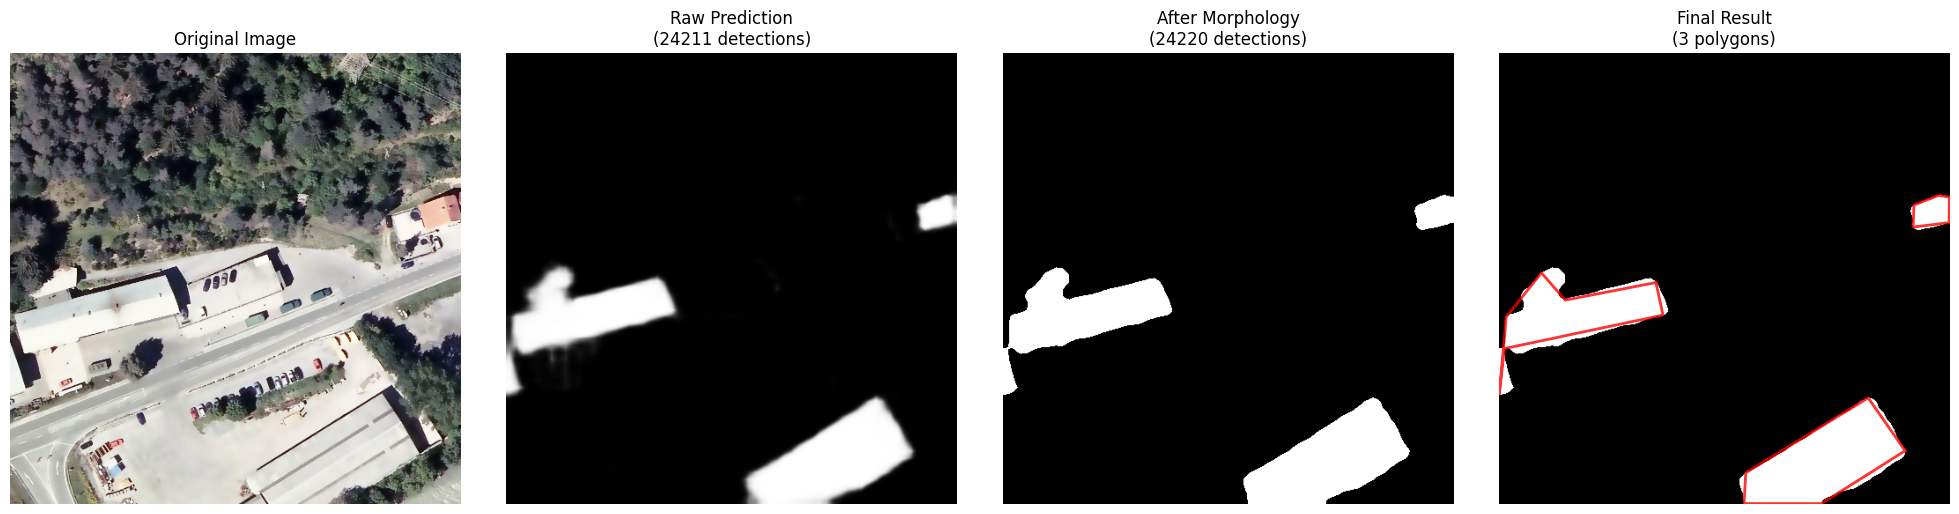


Processing validation sample 2/3...
  Original detections: 26569
  After morphology: 26580
  After filtering: 26473
  Final polygons: 8
  Noise reduction: 100.0%
  Vector file: vector_outputs\validation_sample_2_buildings.geojson

Processing validation sample 3/3...
  Original detections: 53442
  After morphology: 53441
  After filtering: 53301
  Final polygons: 4
  Noise reduction: 100.0%
  Vector file: vector_outputs\validation_sample_3_buildings.geojson

POST-PROCESSING SUMMARY
Best Model Used: DeepLabV3+
Model Comparison:
  DeepLabV3+: 0.7993 ✓ SELECTED
  FPN: 0.6645 
  U-Net: 0.7312 
Average Noise Reduction: 100.0%
Average Building Area: 7690.0 pixels
Total Buildings in Samples: 15
Vector outputs saved to: vector_outputs


In [11]:
def load_iou_only(filepath):
    if not os.path.exists(filepath):
        return 0.0
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    return checkpoint.get("best_iou", 0.0)

deeplabv3_best_iou = load_iou_only("best_deeplabv3.pth")
fpn_best_iou = load_iou_only("best_fpn_model.pth")
unet_best_iou = load_iou_only("final_unet_model.pth")

# Apply morphological operations to refine building masks
def apply_morphological_operations_and_test():
    print("Implementing post-processing pipeline...")

    # Load best model (DeepLabV3+ vs FPN vs U-Net comparison)
    model_scores = {
        'DeepLabV3+': deeplabv3_best_iou,
        'FPN': fpn_best_iou,
        'U-Net': unet_best_iou
    }
    
    # Find the best model
    best_model_name = max(model_scores, key=model_scores.get)
    best_iou = model_scores[best_model_name]
    
    print(f"Using {best_model_name} model (IoU: {best_iou:.4f})")
    
    # Load the corresponding model
    if best_model_name == 'DeepLabV3+':
        best_model = DeepLabV3PlusOptimized(num_classes=1, pretrained=True)
        checkpoint = torch.load('best_deeplabv3.pth', map_location=device, weights_only=False)
    elif best_model_name == 'FPN':
        best_model = OptimizedFPN_ResNet(num_classes=1, pretrained=True)
        checkpoint = torch.load('best_fpn_model.pth', map_location=device, weights_only=False)
    else:  # U-Net
        best_model = UNet(n_channels=rgb_channels, n_classes=segmentation_classes)
        checkpoint = torch.load('final_unet_model.pth', map_location=device, weights_only=False)

    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model.to(device)
    best_model.eval()

    # Create output directory
    output_dir = Path("./vector_outputs")
    output_dir.mkdir(exist_ok=True)

    # Process validation samples for post-processing
    postprocess_results = []

    with torch.no_grad():
        for i, (image, mask) in enumerate(random.sample(list(val_dataset), 3)):
            print(f"\nProcessing validation sample {i+1}/3...")
            image_input = image.unsqueeze(0).to(device)

            # Get prediction
            prediction = best_model(image_input)
            prediction = torch.sigmoid(prediction).squeeze().cpu().numpy()

            # Convert prediction to binary mask
            binary_mask = (prediction > 0.5).astype(np.uint8)
            original_buildings = np.sum(binary_mask > 0)

            print(f"  Original detections: {original_buildings}")

            # Step 1: Apply morphological operations
            # Closing - fill small holes inside buildings
            kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            morph_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_close)

            # Opening - remove small noise outside buildings
            kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_OPEN, kernel_open)

            after_morphology = np.sum(morph_mask > 0)
            print(f"  After morphology: {after_morphology}")

            # Step 2: Remove small buildings (noise)
            labeled_mask = measure.label(morph_mask)
            regions = measure.regionprops(labeled_mask)

            filtered_mask = np.zeros_like(morph_mask)
            min_area = 200  # minimum building area in pixels

            for region in regions:
                if region.area >= min_area:
                    filtered_mask[labeled_mask == region.label] = 1

            after_filtering = np.sum(filtered_mask > 0)
            print(f"  After filtering: {after_filtering}")

            # Step 3: Convert to simplified polygons
            contours, _ = cv2.findContours(filtered_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            simplified_polygons = []
            min_contour_area = 150
            tolerance = 3.0

            for contour in contours:
                area = cv2.contourArea(contour)
                if area < min_contour_area:
                    continue

                # Approximate polygon
                epsilon = tolerance * cv2.arcLength(contour, True) / 100
                approx = cv2.approxPolyDP(contour, epsilon, True)

                if len(approx) >= 3:  # Need at least 3 points for a polygon
                    points = approx.reshape(-1, 2)
                    try:
                        poly = Polygon(points)
                        if poly.is_valid and poly.area > min_contour_area:
                            simplified_polygons.append(poly)
                    except:
                        continue

            final_polygons = len(simplified_polygons)
            print(f"  Final polygons: {final_polygons}")

            # Step 4: Create vector output (GeoJSON)
            features = []
            for j, poly in enumerate(simplified_polygons):
                coords = list(poly.exterior.coords)
                feature = {
                    "type": "Feature",
                    "properties": {
                        "id": j,
                        "building": True,
                        "area": poly.area
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [coords]
                    }
                }
                features.append(feature)

            # Create GeoJSON structure
            geojson = {
                "type": "FeatureCollection",
                "features": features,
                "properties": {
                    "total_buildings": len(features),
                    "bounds": [0, 0, binary_mask.shape[1], binary_mask.shape[0]],
                    "processing_info": f"Automated building extraction with {best_model_name} + post-processing"
                }
            }

            # Save vector output
            vector_file = output_dir / f"validation_sample_{i+1}_buildings.geojson"
            with open(vector_file, 'w') as f:
                json.dump(geojson, f, indent=2)

            # Save processed mask
            mask_file = output_dir / f"validation_sample_{i+1}_processed_mask.png"
            Image.fromarray((filtered_mask * 255).astype(np.uint8)).save(mask_file)

            # Store results
            results = {
                'original_buildings': original_buildings,
                'after_morphology': after_morphology,
                'after_filtering': after_filtering,
                'final_polygons': final_polygons,
                'total_area': sum([poly.area for poly in simplified_polygons]),
                'avg_building_area': sum([poly.area for poly in simplified_polygons]) / len(simplified_polygons) if simplified_polygons else 0,
                'noise_reduction_percent': ((original_buildings - final_polygons) / original_buildings * 100) if original_buildings > 0 else 0
            }
            postprocess_results.append(results)

            print(f"  Noise reduction: {results['noise_reduction_percent']:.1f}%")
            print(f"  Vector file: {vector_file}")

            # Visualization for first sample
            if i == 0:
                fig, axes = plt.subplots(1, 4, figsize=(20, 5))

                # Original image
                axes[0].imshow(image.permute(1, 2, 0))
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                # Raw prediction
                axes[1].imshow(prediction, cmap='gray')
                axes[1].set_title(f'Raw Prediction\n({original_buildings} detections)')
                axes[1].axis('off')

                # After morphological operations
                axes[2].imshow(morph_mask, cmap='gray')
                axes[2].set_title(f'After Morphology\n({after_morphology} detections)')
                axes[2].axis('off')

                # Final result with polygons
                axes[3].imshow(filtered_mask, cmap='gray')
                axes[3].set_title(f'Final Result\n({final_polygons} polygons)')
                axes[3].axis('off')

                # Overlay polygons on the final result
                for poly in simplified_polygons:
                    x, y = poly.exterior.xy
                    axes[3].plot(x, y, 'r-', linewidth=2, alpha=0.8)

                plt.tight_layout()
                plt.savefig(output_dir / "post_processing_comparison.png", dpi=300, bbox_inches='tight')
                plt.show()

    # Summary statistics
    print("\n" + "="*60)
    print("POST-PROCESSING SUMMARY")
    print("="*60)

    avg_noise_reduction = np.mean([r['noise_reduction_percent'] for r in postprocess_results])
    avg_building_area = np.mean([r['avg_building_area'] for r in postprocess_results if r['avg_building_area'] > 0])
    total_buildings_detected = sum([r['final_polygons'] for r in postprocess_results])

    print(f"Best Model Used: {best_model_name}")
    print(f"Model Comparison:")
    for model_name, iou_score in model_scores.items():
        status = "✓ SELECTED" if model_name == best_model_name else ""
        print(f"  {model_name}: {iou_score:.4f} {status}")
    print(f"Average Noise Reduction: {avg_noise_reduction:.1f}%")
    print(f"Average Building Area: {avg_building_area:.1f} pixels")
    print(f"Total Buildings in Samples: {total_buildings_detected}")
    print(f"Vector outputs saved to: {output_dir}")

    return best_model, postprocess_results

# Execute post-processing
best_model, postprocess_results = apply_morphological_operations_and_test()

Advanced Post Processing and Polygon Optimization

In [14]:
def advanced_polygon_processing(geojson_file, output_file=None):
    """Apply advanced polygon processing techniques"""
    print("Applying advanced polygon optimization...")
    
    with open(geojson_file, 'r') as f:
        data = json.load(f)
    
    optimized_features = []
    
    for feature in data['features']:
        coords = feature['geometry']['coordinates'][0]
        
        try:
            # Create polygon
            poly = Polygon(coords)
            
            if not poly.is_valid:
                # Fix invalid polygons
                poly = poly.buffer(0)
            
            # Apply optimizations
            # 1. Simplify polygon (Douglas-Peucker algorithm)
            simplified = poly.simplify(tolerance=2.0, preserve_topology=True)
            
            # 2. Remove very small polygons (noise)
            if simplified.area < 100:
                continue
            
            # 3. Convex hull for very irregular shapes (optional)
            if simplified.area / simplified.convex_hull.area < 0.7:
                # If polygon is very irregular, use convex hull
                simplified = simplified.convex_hull
            
            # 4. Ensure minimum bounding rectangle constraints
            minx, miny, maxx, maxy = simplified.bounds
            if (maxx - minx) < 5 or (maxy - miny) < 5:  # Too small in any dimension
                continue
            
            # Update feature
            feature['geometry']['coordinates'] = [list(simplified.exterior.coords)]
            feature['properties']['area'] = simplified.area
            feature['properties']['perimeter'] = simplified.length
            feature['properties']['compactness'] = (4 * np.pi * simplified.area) / (simplified.length ** 2)
            
            optimized_features.append(feature)
            
        except Exception as e:
            print(f"Skipping problematic polygon: {e}")
            continue
    
    # Update data
    data['features'] = optimized_features
    data['properties']['total_buildings'] = len(optimized_features)
    data['properties']['optimization_applied'] = True
    
    # Save optimized version
    if output_file is None:
        output_file = Path(geojson_file).with_name(Path(geojson_file).stem + "_optimized.geojson")

    
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"Optimized from {len(data['features']) + (len(postprocess_results[0]) if postprocess_results else 0)} to {len(optimized_features)} polygons")
    print(f"Saved to: {output_file}")
    
    return output_file

# Apply advanced processing to generated files
output_dir = Path("./vector_outputs")
for i in range(1, 4):  # Process the 3 validation samples
    geojson_file = output_dir / f"validation_sample_{i}_buildings.geojson"
    if geojson_file.exists():
        advanced_polygon_processing(geojson_file)

Applying advanced polygon optimization...
Optimized from 10 to 3 polygons
Saved to: vector_outputs\validation_sample_1_buildings_optimized.geojson
Applying advanced polygon optimization...
Optimized from 15 to 8 polygons
Saved to: vector_outputs\validation_sample_2_buildings_optimized.geojson
Applying advanced polygon optimization...
Optimized from 11 to 4 polygons
Saved to: vector_outputs\validation_sample_3_buildings_optimized.geojson


Model Ensemble

Creating ensemble model...


c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3+ model loaded successfully


c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FPN model loaded successfully
UNet model loaded successfully
Ensemble created with 3 models: ['deeplabv3', 'fpn', 'unet']


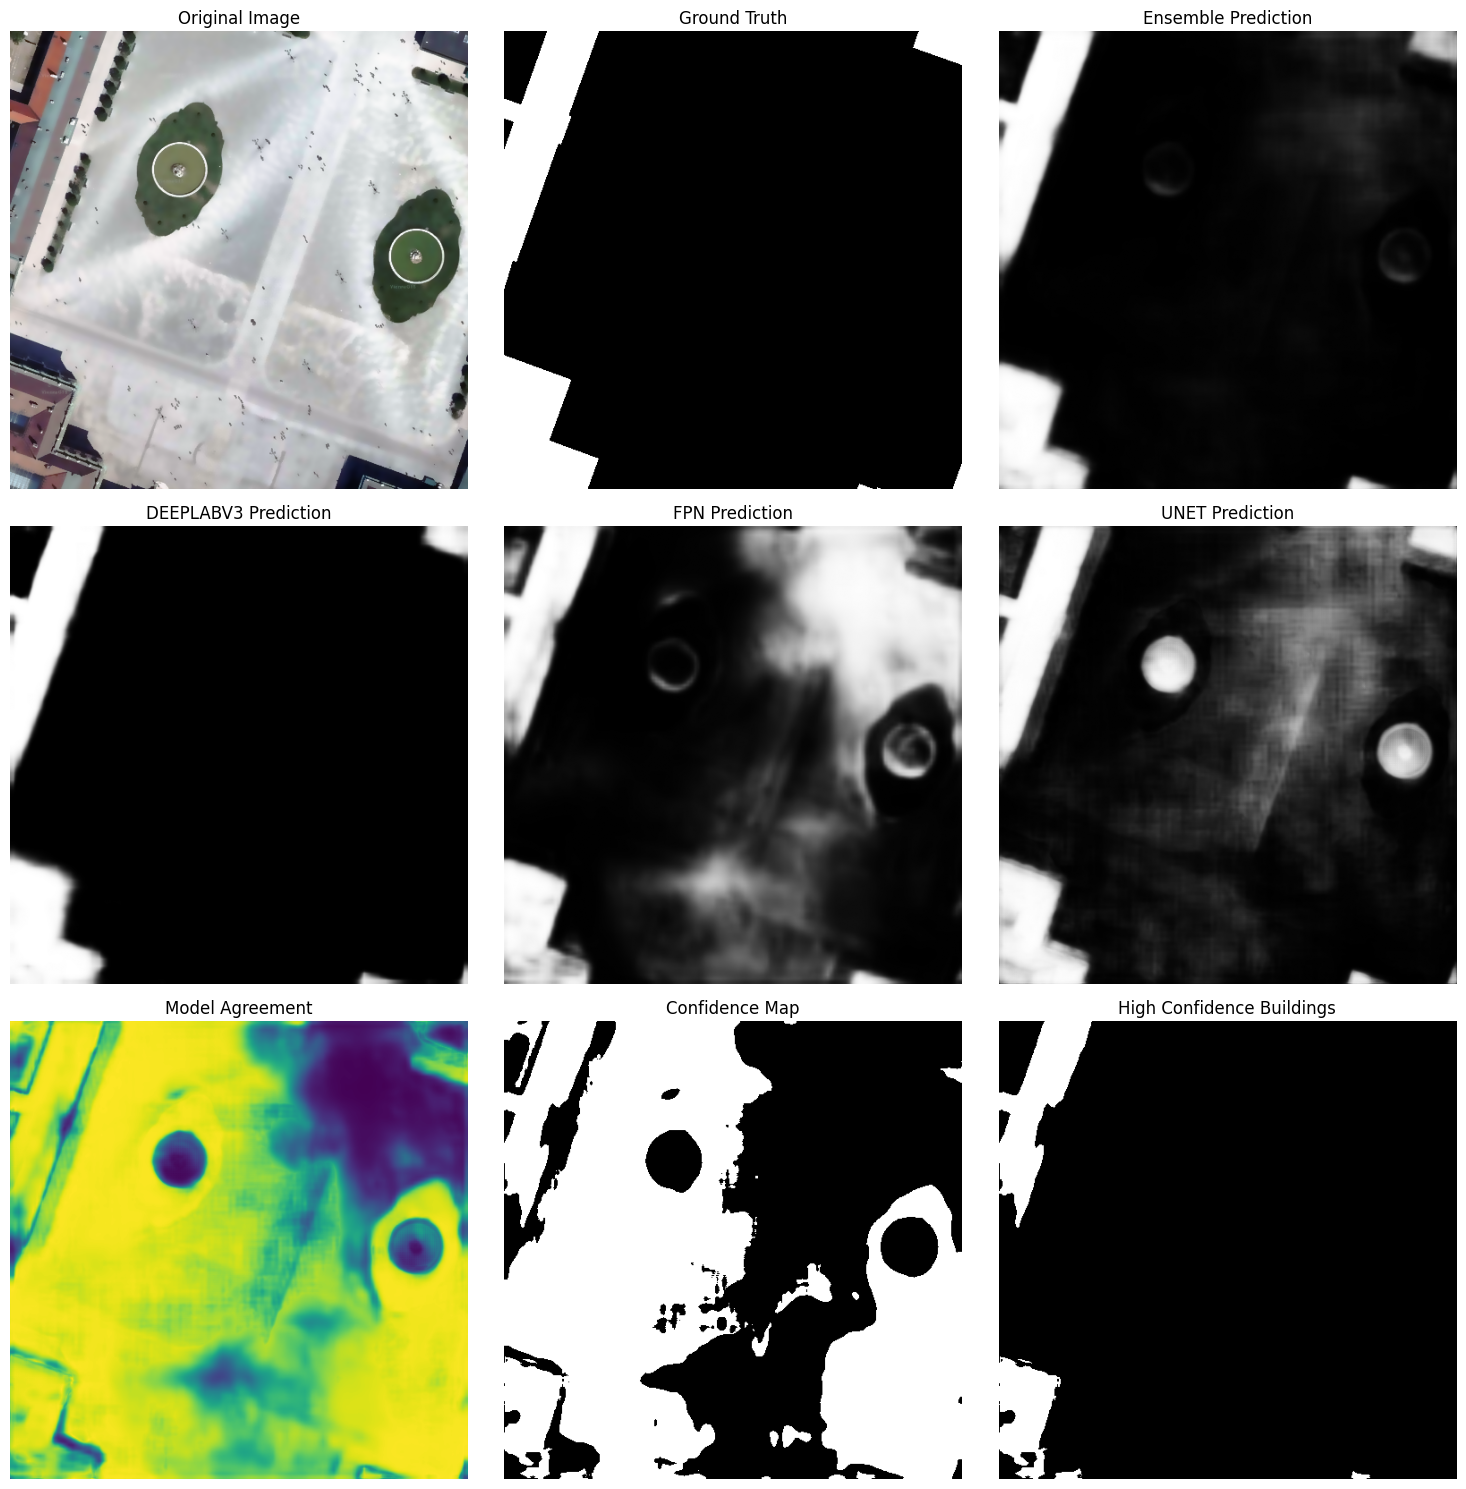

Ensemble model created and tested successfully!
Models in ensemble: ['deeplabv3', 'fpn', 'unet']


In [15]:
class EnsembleModel(nn.Module):
    """Ensemble of DeepLabV3+, FPN, and UNet models"""
    def __init__(self, deeplabv3_path, fpn_path, unet_path):
        super(EnsembleModel, self).__init__()
        
        self.models = {}
        self.available_models = []
        
        # Load DeepLabV3+ model
        try:
            self.deeplabv3 = DeepLabV3PlusOptimized(num_classes=1, pretrained=True)
            deeplabv3_checkpoint = torch.load(deeplabv3_path, map_location='cpu', weights_only=False)
            self.deeplabv3.load_state_dict(deeplabv3_checkpoint['model_state_dict'])
            self.models['deeplabv3'] = self.deeplabv3
            self.available_models.append('deeplabv3')
            print("DeepLabV3+ model loaded successfully")
        except FileNotFoundError:
            print("DeepLabV3+ model not found, skipping...")
        
        # Load FPN model
        try:
            self.fpn = OptimizedFPN_ResNet(num_classes=1, pretrained=True)
            fpn_checkpoint = torch.load(fpn_path, map_location='cpu', weights_only=False)
            self.fpn.load_state_dict(fpn_checkpoint['model_state_dict'])
            self.models['fpn'] = self.fpn
            self.available_models.append('fpn')
            print("FPN model loaded successfully")
        except FileNotFoundError:
            print("FPN model not found, skipping...")
        
        # Load UNet model
        try:
            self.unet = UNet(n_channels=rgb_channels, n_classes=segmentation_classes)
            unet_checkpoint = torch.load(unet_path, map_location='cpu', weights_only=False)
            self.unet.load_state_dict(unet_checkpoint['model_state_dict'])
            self.models['unet'] = self.unet
            self.available_models.append('unet')
            print("UNet model loaded successfully")
        except FileNotFoundError:
            print("UNet model not found, skipping...")
        
        if not self.available_models:
            raise ValueError("No models could be loaded for ensemble!")
        
        # Fusion weights (learnable) - dynamically sized based on available models
        self.fusion_weights = nn.Parameter(torch.ones(len(self.available_models)) / len(self.available_models))
        
        print(f"Ensemble created with {len(self.available_models)} models: {self.available_models}")
        
    def forward(self, x):
        # Get predictions from all available models
        predictions = {}
        for model_name in self.available_models:
            predictions[model_name] = self.models[model_name](x)
        
        # Weighted ensemble
        weights = F.softmax(self.fusion_weights, dim=0)
        ensemble_pred = torch.zeros_like(list(predictions.values())[0])
        
        for i, model_name in enumerate(self.available_models):
            ensemble_pred += weights[i] * predictions[model_name]
        
        return ensemble_pred, predictions

def create_confidence_map_multi(predictions, threshold=0.1):
    """Create confidence map based on multi-model agreement"""
    if len(predictions) < 2:
        # If only one model, return high confidence everywhere
        pred_prob = torch.sigmoid(list(predictions.values())[0])
        confidence = torch.ones_like(pred_prob)
        return confidence, confidence
    
    # Convert to probabilities
    pred_probs = {name: torch.sigmoid(pred) for name, pred in predictions.items()}
    
    # Calculate pairwise agreements
    model_names = list(pred_probs.keys())
    agreements = []
    
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            agreement = 1.0 - torch.abs(pred_probs[model_names[i]] - pred_probs[model_names[j]])
            agreements.append(agreement)
    
    # Average agreement across all pairs
    mean_agreement = torch.stack(agreements).mean(dim=0)
    
    # High confidence where models agree
    confidence = (mean_agreement > (1.0 - threshold)).float()
    
    return confidence, mean_agreement

# Create ensemble model if models exist
try:
    print("Creating ensemble model...")
    ensemble_model = EnsembleModel('best_deeplabv3.pth', 'best_fpn_model.pth', 'final_unet_model.pth')
    ensemble_model.to(device)
    ensemble_model.eval()
    
    # Test ensemble on validation sample
    with torch.no_grad():
        sample_image, sample_mask = val_dataset[0]
        image_input = sample_image.unsqueeze(0).to(device)
        
        ensemble_pred, predictions = ensemble_model(image_input)
        confidence, agreement = create_confidence_map_multi(predictions)
        
        # Apply confidence-based filtering
        ensemble_prob = torch.sigmoid(ensemble_pred)
        high_confidence_mask = (confidence > 0.8) & (ensemble_prob > 0.5)
        
        # Visualize ensemble results - adjust grid based on number of models
        num_models = len(predictions)
        fig, axes = plt.subplots(3, max(3, num_models), figsize=(5*max(3, num_models), 15))
        
        # Ensure axes is 2D
        if axes.ndim == 1:
            axes = axes.reshape(3, -1)
        
        # Row 1: Original image, ground truth, ensemble prediction
        axes[0, 0].imshow(sample_image.permute(1, 2, 0))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(sample_mask.squeeze(), cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(ensemble_prob.squeeze().cpu(), cmap='gray')
        axes[0, 2].set_title('Ensemble Prediction')
        axes[0, 2].axis('off')
        
        # Hide extra columns in first row if needed
        for i in range(3, axes.shape[1]):
            axes[0, i].axis('off')
        
        # Row 2: Individual model predictions
        for i, (model_name, pred) in enumerate(predictions.items()):
            if i < axes.shape[1]:
                pred_prob = torch.sigmoid(pred)
                axes[1, i].imshow(pred_prob.squeeze().cpu(), cmap='gray')
                axes[1, i].set_title(f'{model_name.upper()} Prediction')
                axes[1, i].axis('off')
        
        # Hide extra columns in second row if needed
        for i in range(len(predictions), axes.shape[1]):
            axes[1, i].axis('off')
        
        # Row 3: Agreement, confidence, high confidence predictions
        axes[2, 0].imshow(agreement.squeeze().cpu(), cmap='viridis')
        axes[2, 0].set_title('Model Agreement')
        axes[2, 0].axis('off')
        
        axes[2, 1].imshow(confidence.squeeze().cpu(), cmap='gray')
        axes[2, 1].set_title('Confidence Map')
        axes[2, 1].axis('off')
        
        axes[2, 2].imshow(high_confidence_mask.squeeze().cpu(), cmap='gray')
        axes[2, 2].set_title('High Confidence Buildings')
        axes[2, 2].axis('off')
        
        # Hide extra columns in third row if needed
        for i in range(3, axes.shape[1]):
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Ensemble model created and tested successfully!")
        print(f"Models in ensemble: {ensemble_model.available_models}")
        
except Exception as e:
    print(f"Ensemble model creation failed: {e}")

Comprehensive Evaluation and Metrics

Starting comprehensive model evaluation...


c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3+ model loaded for evaluation


c:\Users\ayush\Programs\College\NTCC\Vector-Map.io\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FPN-ResNet model loaded for evaluation
UNet model loaded for evaluation
DeepLabV3+ model loaded successfully
FPN model loaded successfully
UNet model loaded successfully
Ensemble created with 3 models: ['deeplabv3', 'fpn', 'unet']
Ensemble model loaded for evaluation
Found 4 models to evaluate: ['DeepLabV3+', 'FPN-ResNet', 'UNet', 'Ensemble']

Evaluating DeepLabV3+...


Evaluating DeepLabV3+:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', arg


Evaluating FPN-ResNet...


Evaluating FPN-ResNet:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', arg


Evaluating UNet...


Evaluating UNet:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', arg


Evaluating Ensemble...


Evaluating Ensemble:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_644\664534799.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', arg


COMPREHENSIVE MODEL EVALUATION RESULTS

DeepLabV3+:
  IoU:           0.7918 ± 0.0511
  Precision:     0.9047 ± 0.0329
  Recall:        0.8632 ± 0.0430
  F1-Score:      0.8829 ± 0.0321
  Inference:     16.18 ± 67.07 ms
  Parameters:    26,457,730
  Model Size:    100.93 MB
  Training IoU:  0.7993

FPN-ResNet:
  IoU:           0.6602 ± 0.0650
  Precision:     0.7684 ± 0.0585
  Recall:        0.8255 ± 0.0673
  F1-Score:      0.7934 ± 0.0482
  Inference:     10.24 ± 9.30 ms
  Parameters:    25,286,785
  Model Size:    96.46 MB
  Training IoU:  0.6645

UNet:
  IoU:           0.7233 ± 0.0655
  Precision:     0.8480 ± 0.0449
  Recall:        0.8312 ± 0.0681
  F1-Score:      0.8377 ± 0.0453
  Inference:     8.69 ± 32.58 ms
  Parameters:    31,037,633
  Model Size:    118.40 MB
  Training IoU:  0.7312

Ensemble:
  IoU:           0.7759 ± 0.0552
  Precision:     0.8834 ± 0.0370
  Recall:        0.8641 ± 0.0518
  F1-Score:      0.8727 ± 0.0359
  Inference:     23.20 ± 4.95 ms
  Parameters:    82

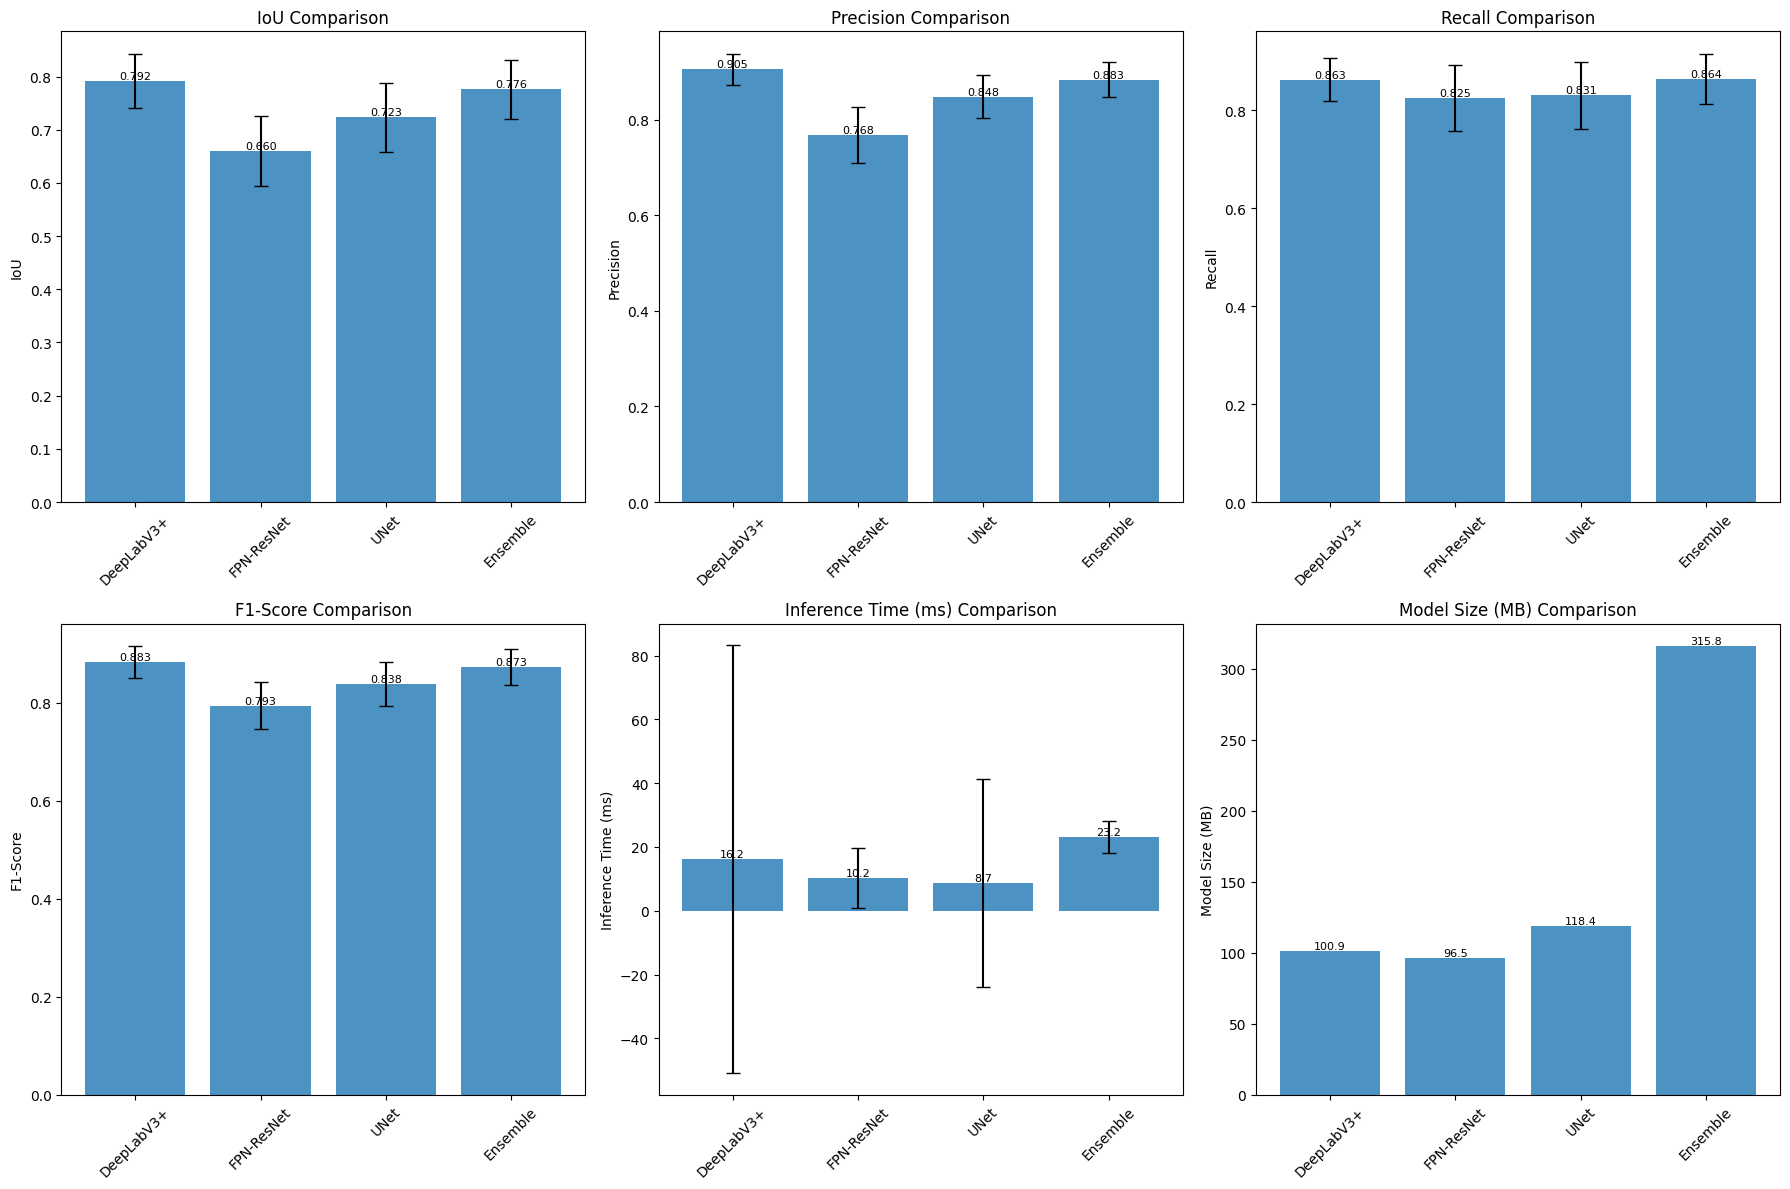

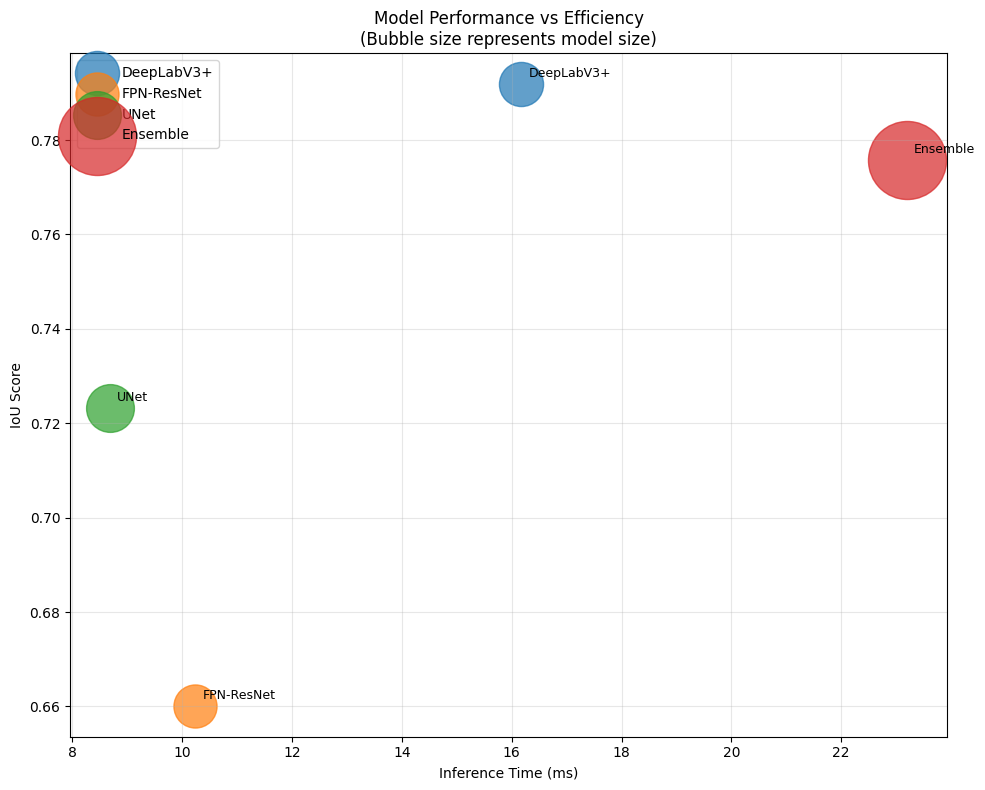


Detailed results saved to: evaluation_results.json

SUMMARY TABLE
Model           IoU      F1       Time(ms)   Size(MB)   Params      
----------------------------------------------------------------------------------------------------
DeepLabV3+      0.7918   0.8829   16.18      100.93     26,457,730  
FPN-ResNet      0.6602   0.7934   10.24      96.46      25,286,785  
UNet            0.7233   0.8377   8.69       118.40     31,037,633  
Ensemble        0.7759   0.8727   23.20      315.79     82,782,151  


In [16]:
def comprehensive_model_evaluation():
    """Comprehensive evaluation of all trained models including UNet"""
    print("Starting comprehensive model evaluation...")
    
    models_to_evaluate = []
    
    # Add DeepLabV3+ if available
    if Path('best_deeplabv3.pth').exists():
        try:
            deeplabv3_eval = DeepLabV3PlusOptimized(num_classes=1, pretrained=True)
            checkpoint = torch.load('best_deeplabv3.pth', map_location=device, weights_only=False)
            deeplabv3_eval.load_state_dict(checkpoint['model_state_dict'])
            best_iou = checkpoint.get('best_iou', 0.0) if 'best_iou' in checkpoint else globals().get('deeplabv3_best_iou', 0.0)
            models_to_evaluate.append(('DeepLabV3+', deeplabv3_eval, best_iou))
            print("DeepLabV3+ model loaded for evaluation")
        except Exception as e:
            print(f"Failed to load DeepLabV3+: {e}")
    
    # Add FPN if available
    if Path('best_fpn_model.pth').exists():
        try:
            fpn_eval = OptimizedFPN_ResNet(num_classes=1, pretrained=True)
            checkpoint = torch.load('best_fpn_model.pth', map_location=device, weights_only=False)
            fpn_eval.load_state_dict(checkpoint['model_state_dict'])
            best_iou = checkpoint.get('best_iou', 0.0) if 'best_iou' in checkpoint else globals().get('fpn_best_iou', 0.0)
            models_to_evaluate.append(('FPN-ResNet', fpn_eval, best_iou))
            print("FPN-ResNet model loaded for evaluation")
        except Exception as e:
            print(f"Failed to load FPN-ResNet: {e}")
    
    # Add UNet if available
    if Path('final_unet_model.pth').exists():
        try:
            unet_eval = UNet(n_channels=rgb_channels, n_classes=segmentation_classes)
            checkpoint = torch.load('final_unet_model.pth', map_location=device, weights_only=False)
            unet_eval.load_state_dict(checkpoint['model_state_dict'])
            best_iou = checkpoint.get('best_iou', 0.0) if 'best_iou' in checkpoint else globals().get('unet_best_iou', 0.0)
            models_to_evaluate.append(('UNet', unet_eval, best_iou))
            print("UNet model loaded for evaluation")
        except Exception as e:
            print(f"Failed to load UNet: {e}")
    
    # Add ensemble if available
    try:
        if len(models_to_evaluate) >= 2:
            ensemble_eval = EnsembleModel('best_deeplabv3.pth', 'best_fpn_model.pth', 'final_unet_model.pth')
            models_to_evaluate.append(('Ensemble', ensemble_eval, 0.0))
            print("Ensemble model loaded for evaluation")
    except Exception as e:
        print(f"Ensemble model not available: {e}")
    
    if not models_to_evaluate:
        print("No trained models found for evaluation!")
        return {}
    
    print(f"Found {len(models_to_evaluate)} models to evaluate: {[name for name, _, _ in models_to_evaluate]}")
    
    # Evaluation metrics
    evaluation_results = {}
    
    for model_name, model, best_iou in models_to_evaluate:
        print(f"\nEvaluating {model_name}...")
        model.to(device)
        model.eval()
        
        all_ious = []
        all_precisions = []
        all_recalls = []
        all_f1s = []
        inference_times = []
        
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Evaluating {model_name}")):
                image = image.to(device, non_blocking=True)
                mask = mask.to(device, non_blocking=True)
                
                # Measure inference time
                start_time = time.time()
                
                with autocast():
                    if model_name == 'Ensemble':
                        prediction, _ = model(image)  # Ensemble returns tuple
                    else:
                        prediction = model(image)
                    prediction = torch.sigmoid(prediction)
                
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                # Calculate metrics
                precision, recall, f1, iou = calculate_metrics(prediction, mask)
                
                all_ious.append(iou)
                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1s.append(f1)
                
                # Break after reasonable number of samples for speed
                if i >= 50:
                    break
        
        # Compute statistics
        results = {
            'mean_iou': np.mean(all_ious),
            'std_iou': np.std(all_ious),
            'mean_precision': np.mean(all_precisions),
            'std_precision': np.std(all_precisions),
            'mean_recall': np.mean(all_recalls),
            'std_recall': np.std(all_recalls),
            'mean_f1': np.mean(all_f1s),
            'std_f1': np.std(all_f1s),
            'mean_inference_time': np.mean(inference_times),
            'std_inference_time': np.std(inference_times),
            'best_training_iou': best_iou,
            'num_parameters': sum(p.numel() for p in model.parameters()),
            'model_size_mb': sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
        }
        
        evaluation_results[model_name] = results
    
    # Print comprehensive results
    print("\n" + "="*100)
    print("COMPREHENSIVE MODEL EVALUATION RESULTS")
    print("="*100)
    
    for model_name, results in evaluation_results.items():
        print(f"\n{model_name}:")
        print(f"  IoU:           {results['mean_iou']:.4f} ± {results['std_iou']:.4f}")
        print(f"  Precision:     {results['mean_precision']:.4f} ± {results['std_precision']:.4f}")
        print(f"  Recall:        {results['mean_recall']:.4f} ± {results['std_recall']:.4f}")
        print(f"  F1-Score:      {results['mean_f1']:.4f} ± {results['std_f1']:.4f}")
        print(f"  Inference:     {results['mean_inference_time']*1000:.2f} ± {results['std_inference_time']*1000:.2f} ms")
        print(f"  Parameters:    {results['num_parameters']:,}")
        print(f"  Model Size:    {results['model_size_mb']:.2f} MB")
        print(f"  Training IoU:  {results['best_training_iou']:.4f}")
    
    # Create comparison visualization
    if len(evaluation_results) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        models = list(evaluation_results.keys())
        metrics = ['mean_iou', 'mean_precision', 'mean_recall', 'mean_f1', 'mean_inference_time', 'model_size_mb']
        metric_names = ['IoU', 'Precision', 'Recall', 'F1-Score', 'Inference Time (ms)', 'Model Size (MB)']
        
        for i, (metric, name) in enumerate(zip(metrics, metric_names)):
            ax = axes[i//3, i%3]
            values = [evaluation_results[model][metric] for model in models]
            
            if metric == 'mean_inference_time':
                values = [v * 1000 for v in values]  # Convert to ms
                errors = [evaluation_results[model]['std_inference_time'] * 1000 for model in models]
            elif metric in ['mean_iou', 'mean_precision', 'mean_recall', 'mean_f1']:
                errors = [evaluation_results[model][metric.replace('mean_', 'std_')] for model in models]
            else:
                errors = None
            
            bars = ax.bar(models, values, yerr=errors, capsize=5, alpha=0.8)
            ax.set_title(f'{name} Comparison')
            ax.set_ylabel(name)
            ax.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                if metric == 'model_size_mb':
                    label = f'{value:.1f}'
                elif metric == 'mean_inference_time':
                    label = f'{value:.1f}'
                else:
                    label = f'{value:.3f}'
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       label, ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create performance vs efficiency plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        for model_name in models:
            results = evaluation_results[model_name]
            ax.scatter(results['mean_inference_time']*1000, results['mean_iou'], 
                      s=results['model_size_mb']*10, alpha=0.7, label=model_name)
            ax.annotate(model_name, 
                       (results['mean_inference_time']*1000, results['mean_iou']),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax.set_xlabel('Inference Time (ms)')
        ax.set_ylabel('IoU Score')
        ax.set_title('Model Performance vs Efficiency\n(Bubble size represents model size)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_efficiency.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Save results to JSON
    with open('evaluation_results.json', 'w') as f:
        # Convert numpy types to Python types for JSON serialization
        json_results = {}
        for model_name, results in evaluation_results.items():
            json_results[model_name] = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                                      for k, v in results.items()}
        json.dump(json_results, f, indent=2)
    
    print(f"\nDetailed results saved to: evaluation_results.json")
    
    # Print summary table
    print("\n" + "="*100)
    print("SUMMARY TABLE")
    print("="*100)
    print(f"{'Model':<15} {'IoU':<8} {'F1':<8} {'Time(ms)':<10} {'Size(MB)':<10} {'Params':<12}")
    print("-"*100)
    for model_name, results in evaluation_results.items():
        print(f"{model_name:<15} {results['mean_iou']:<8.4f} {results['mean_f1']:<8.4f} "
              f"{results['mean_inference_time']*1000:<10.2f} {results['model_size_mb']:<10.2f} "
              f"{results['num_parameters']:<12,}")
    
    return evaluation_results

# Run comprehensive evaluation
evaluation_results = comprehensive_model_evaluation()